In [290]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

In [291]:
import warnings
warnings.filterwarnings(action='ignore')

In [292]:
df = pd.read_csv('../data/main_df2.csv', index_col=0)

## Classification 문제 정의

* 농도를 정확히 예측하는 것보다는 좋을지 나쁠지만 분류하는 문제로 정의
* 앞서 EDA에서 0~40사이가 대부분이고, 나머지는 비슷한 수준이라 40을 기준으로 0, 1 구분함

In [293]:
df['is_bad'] = np.where(df['redust']>=40, 1, 0)
df['is_bad'].value_counts()

0    859
1    281
Name: is_bad, dtype: int64

## 데이터 상관관계 확인

In [294]:
# model_df = model_df.drop(['date_cd', 'dong'], axis=1)
df = df.drop(['date_cd', 'dong', 'redust', ], axis=1)

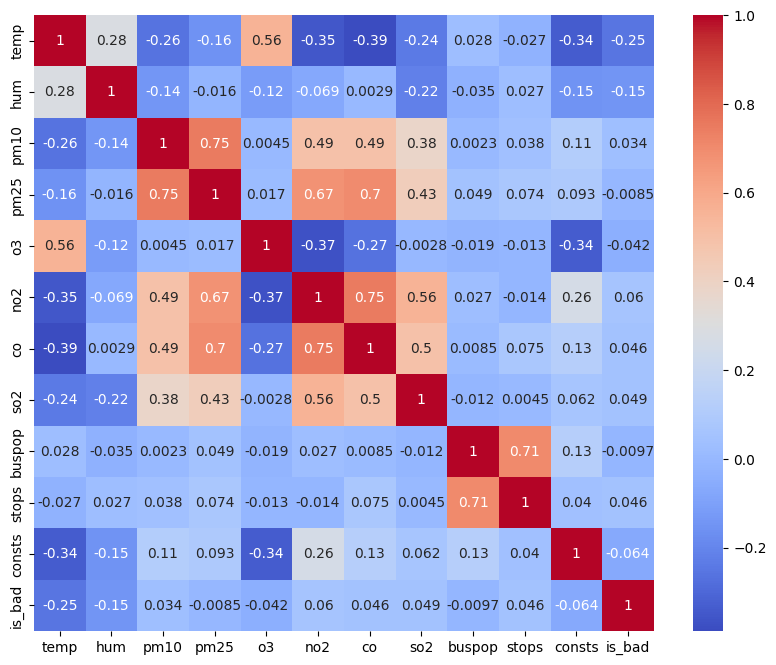

In [295]:
corr2 = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr2, annot=True, cmap='coolwarm')
plt.show()

In [296]:
X = df.drop('is_bad', axis=1)
y = df['is_bad']

In [297]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=0,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    stratify=y_trainval,
    random_state=0,
)

In [298]:
training_f1 = []
valid_f1 = []
hyper1 = []
hyper2 = []

msl_settings = [2, 5, 7]
md_settings = [3, 5, 7, 9]
for msl in msl_settings:
    for md in md_settings:
        dt_clf = DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md, random_state=0)
        dt_clf.fit(X_train, y_train)

        y_train_hat = dt_clf.predict(X_train)
        y_valid_hat = dt_clf.predict(X_val)

        hyper1.append(msl)
        hyper2.append(md)
        training_f1.append(f1_score(y_train, y_train_hat))
        valid_f1.append(f1_score(y_val, y_valid_hat))

In [299]:
dt_result = pd.DataFrame({
    "min_samples_leaf":hyper1,
    "max_depth":hyper2,
    "train f1": training_f1,
    "validation f1": valid_f1
})

In [300]:
dt_result.sort_values('validation f1', ascending=False).head()

,min_samples_leaf,max_depth,train f1,validation f1
7,5,9,0.693727,0.430108
2,2,7,0.655602,0.376471
10,7,7,0.553191,0.375000
11,7,9,0.638462,0.375000
6,5,7,0.594142,0.370370


In [301]:
training_f1 = []
valid_f1 = []
hyper1 = []
hyper2 = []

n_settings = [50, 100, 300]
md_settings = [3, 5, 7, 9]
for n in n_settings:
    for md in md_settings:
        # model training with labeled training data
        rf_clf = RandomForestClassifier(n_estimators=n, max_depth=md, random_state=0)
        rf_clf.fit(X_train, y_train)

        # prediction
        y_train_hat = rf_clf.predict(X_train)
        y_valid_hat = rf_clf.predict(X_val)

        # evaluation    
        hyper1.append(n)
        hyper2.append(md)
        training_f1.append(f1_score(y_train, y_train_hat))
        valid_f1.append(f1_score(y_val, y_valid_hat))

In [302]:
rf_result = pd.DataFrame({"n_estimators":hyper1, "max_depth":hyper2, "train f1": training_f1, "validation f1": valid_f1})

In [303]:
rf_result.sort_values('validation f1', ascending=False).head()

,n_estimators,max_depth,train f1,validation f1
11,300,9,0.887324,0.488372
7,100,9,0.875445,0.452381
2,50,7,0.699588,0.419753
3,50,9,0.863309,0.409639
10,300,7,0.712551,0.405063


In [304]:
training_f1 = []
valid_f1 = []
hyper1 = []
hyper2 = []

n_settings = [50, 100, 300, 500]
for n in n_settings:
    # model training with labeled training data
    rf_clf = AdaBoostClassifier(n_estimators=n, random_state=0)
    rf_clf.fit(X_train, y_train)

    # prediction
    y_train_hat = rf_clf.predict(X_train)
    y_valid_hat = rf_clf.predict(X_val)

    # evaluation    
    hyper1.append(n)
    training_f1.append(f1_score(y_train, y_train_hat))
    valid_f1.append(f1_score(y_val, y_valid_hat))

In [305]:
ada_result = pd.DataFrame({"n_estimators":hyper1, "train f1": training_f1, "validation f1": valid_f1})
ada_result.sort_values('validation f1', ascending=False).head()

,n_estimators,train f1,validation f1
1,100,0.610442,0.459770
2,300,0.760148,0.442105
0,50,0.531120,0.426966
3,500,0.859155,0.420000


## 최종 분류 모델 선정

### imbalanced 문제 있어 threshold 조정
* threshold 바꿔가며 잘 precision, recall의 차이가 적은 지점 발견

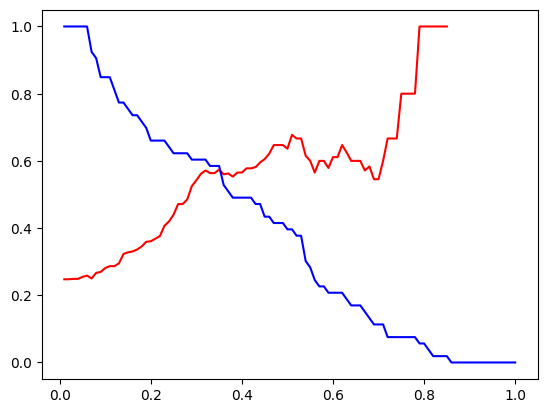

In [306]:
clf = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=0)
clf.fit(X_train, y_train)
y_val_hat = clf.predict_proba(X_val)

def by_boundary(y, boundary):
    Y = y.copy()
    return (Y[:, 1] > boundary).astype(int)

y1 = []
y2 = []
for i in np.linspace(0.01,1,100):
    y_pred = by_boundary(y_val_hat, i)
    cf_m = confusion_matrix(y_val, y_pred)
    y1.append(cf_m[1,1]/(cf_m[1,1]+cf_m[0,1]))
    y2.append(cf_m[1,1]/(cf_m[1,1]+cf_m[1,0]))

plt.plot(np.linspace(0.01,1,100), y1, label = 'precision', color = 'red')
plt.plot(np.linspace(0.01,1,100), y2, label = 'recall', color = 'blue')

## 최종 성능 평가

In [307]:
fin_clf = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=0)
fin_clf.fit(X_trainval, y_trainval)
y_test_hat = fin_clf.predict_proba(X_test)
y_test_pred = by_boundary(y_test_hat, 0.37)

In [308]:
print(accuracy_score(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.7929824561403509
0.5354330708661418
0.5964912280701754
0.4857142857142857


array([[192,  23],
       [ 36,  34]])

<BarContainer object of 11 artists>

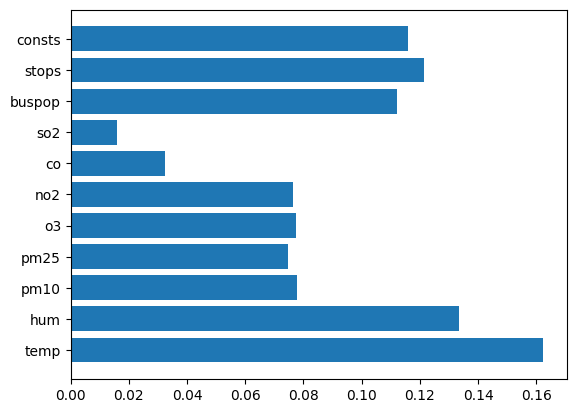

In [309]:
plt.barh(df.drop('is_bad', axis=1).columns, fin_clf.feature_importances_)

## 테스트셋 분류 결과 분석

In [310]:
X_test['is_bad'] = y_test
X_test['model_pred'] = y_test_pred

In [311]:
X_test[(X_test['is_bad']==1) & (X_test['model_pred']==1)].mean()

temp              9.470588
hum              45.970588
pm10             38.088235
pm25             17.000000
o3                0.026706
no2               0.023412
co                0.435294
so2               0.002971
buspop        31014.882353
stops            79.470588
consts           29.852941
is_bad            1.000000
model_pred        1.000000
dtype: float64

In [315]:
X_test[(X_test['is_bad']==0) & (X_test['model_pred']==1)].mean()

temp              9.782609
hum              41.043478
pm10             35.000000
pm25             15.391304
o3                0.033783
no2               0.017522
co                0.439130
so2               0.002957
buspop        26938.826087
stops            74.956522
consts           31.086957
is_bad            0.000000
model_pred        1.000000
dtype: float64

In [316]:
X_test[(X_test['is_bad']==1) & (X_test['model_pred']==0)].mean()

temp             19.138889
hum              57.750000
pm10             34.972222
pm25             19.250000
o3                0.035111
no2               0.022139
co                0.441667
so2               0.003000
buspop        22906.833333
stops            57.583333
consts           23.888889
is_bad            1.000000
model_pred        0.000000
dtype: float64

In [317]:
X_test[(X_test['is_bad']==0) & (X_test['model_pred']==0)].mean()

temp             21.395833
hum              58.848958
pm10             31.609375
pm25             17.281250
o3                0.030411
no2               0.019891
co                0.407292
so2               0.002771
buspop        28643.515625
stops            65.989583
consts           30.192708
is_bad            0.000000
model_pred        0.000000
dtype: float64